# Aplicação do Algoritmo LIME em radiografias torácicas
***

### Importação dos pacotes básicos

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input

### Importação do modelo CNN treinado

In [2]:
# importando o modelo previamento definido e treinado
import urllib.request as url
# definindo o caminho de download e o arquivo de recebimento 
path = 'https://raw.githubusercontent.com/Alyssonmach/grad-cam-implementation/main/assets/keras_model.py'
file_ = 'keras_model.py'
# fazendo a importação dos scripts
url.urlretrieve(path, file_)
# importando os scripts da definição do modelo
from keras_model import pre_processamento

In [3]:
# importando o modelo e os exemplos de teste
model_grad, model_base, (x, y) = pre_processamento(test_data = False)

total de imagens disponíveis: 15000

total de dados após a filtração: 13948

quantidade de dados rotulados como normais: 10606
quantidade de dados rotulados como anormais: 3342

quantidade de dados rotulados como normais (balanceado): 3287
quantidade de dados rotulados como anormais: 3342

quantidade de imagens de treinamento: 4242
quantidade de rótulos de treinamento: 4242
quantidade de imagens de teste: 1326
quantidade de rótulos de teste: 1326
quantidade de imagens de validação: 1061
quantidade de rótulos de validação: 1061 

Found 4242 validated image filenames.
Found 1061 validated image filenames.
Found 1326 validated image filenames.


In [4]:
# definindo o caminho das imagens de teste
path1 = '/content/drive/MyDrive/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.jpg'
path2 = '/content/drive/MyDrive/vinbigdata/test/041c40e3f03d9af32b594c5186575a61.jpg'
path3 = '/content/drive/MyDrive/vinbigdata/test/3bde9f07f146da27d795709456f6ab17.jpg'
path4 = '/content/drive/MyDrive/vinbigdata/test/037503b94eb68a16587a78bce365e681.jpg'

### Algoritmo LIME

In [ ]:
# instalando o pacote do lime
!pip install lime

In [6]:
# definido o caminho dos scripts e o arquivo receptor
path = 'https://raw.githubusercontent.com/Alyssonmach/grad-cam-implementation/main/assets/lime_plots.py'
file_ = 'lime_plots.py'
# requisitando os scripts do repositório
url.urlretrieve(path, file_)
# importando os scripts do algoritmo lime
from lime_plots import lime_plot 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image predict: [[5.033603]] %


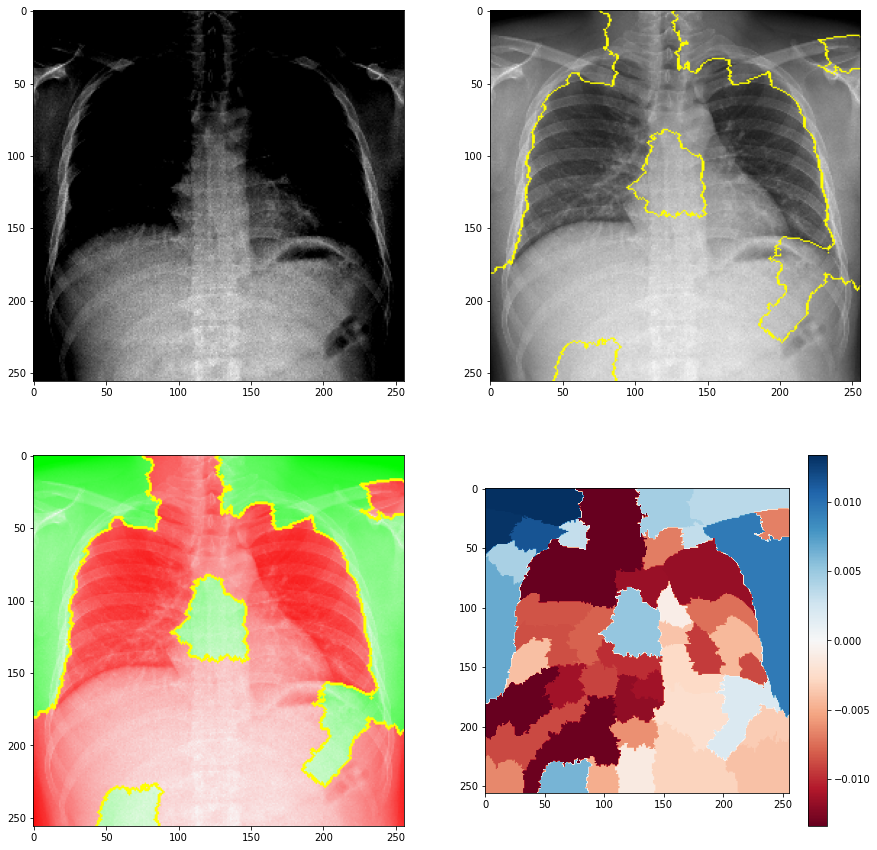

In [7]:
# plotando os gráficos do algoritmo lime
heatmap = lime_plot(path = path1, img_size = (256, 256), model_base = model_base, 
                    top_labels = 1, label_select = 0, preprocess_input = preprocess_input,
                    num_samples = 3000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image predict: [[11.5083275]] %


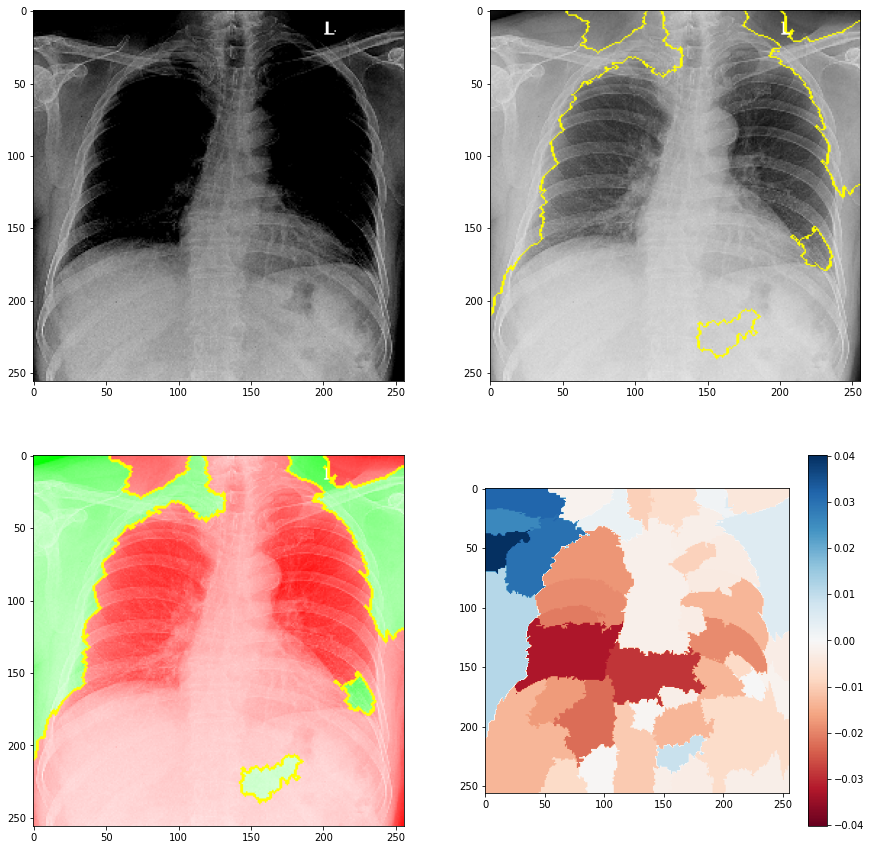

In [8]:
# plotando os gráficos do algoritmo lime
heatmap = lime_plot(path = path2, img_size = (256, 256), model_base = model_base, 
                    top_labels = 1, label_select = 0, preprocess_input = preprocess_input,
                    num_samples = 3000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image predict: [[0.43479294]] %


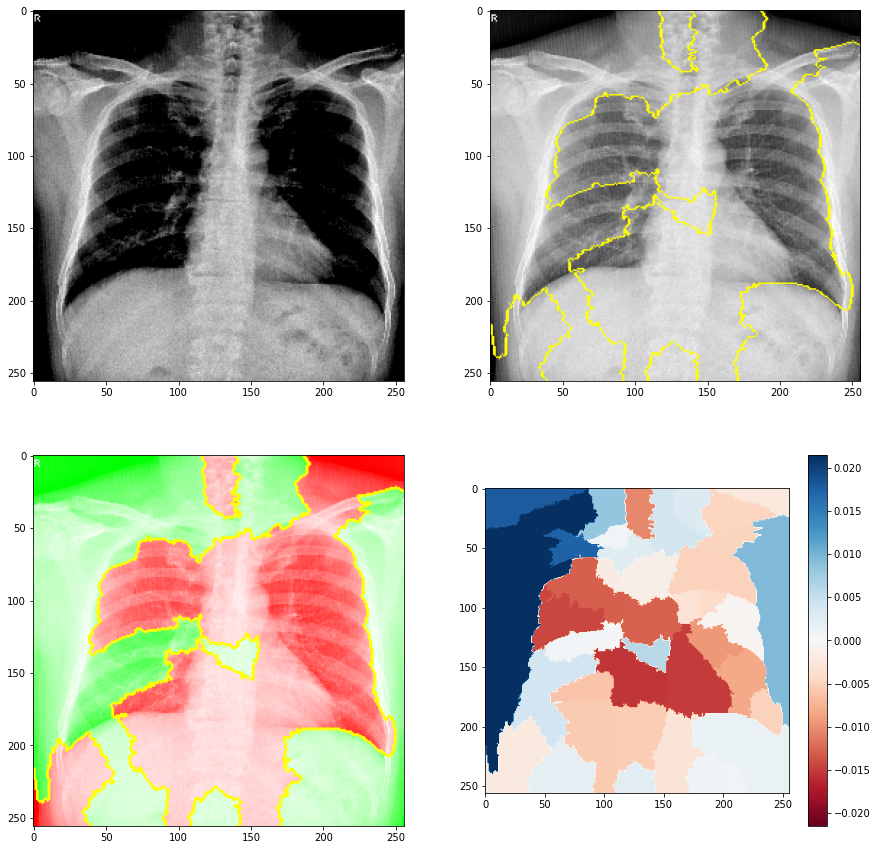

In [9]:
# plotando os gráficos do algoritmo lime
heatmap = lime_plot(path = path3, img_size = (256, 256), model_base = model_base, 
                    top_labels = 1, label_select = 0, preprocess_input = preprocess_input,
                    num_samples = 3000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image predict: [[99.88438]] %


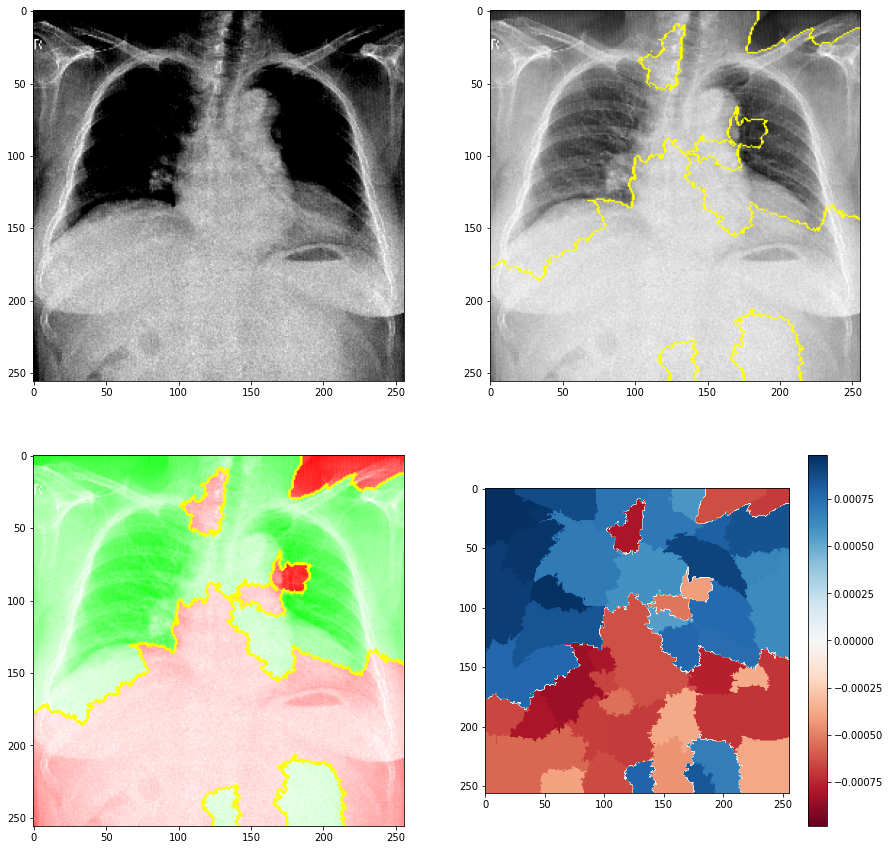

In [10]:
# plotando os gráficos do algoritmo lime
heatmap = lime_plot(path = path4, img_size = (256, 256), model_base = model_base, 
                    top_labels = 1, label_select = 0, preprocess_input = preprocess_input,
                    num_samples = 3000)